---
layout: default
title: "Deep Learning - RNN - Transformer network"
categories: deeplearning
permalink: /ML48/
order: 48
comments: true
---

In [1]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["mathtext.fontset"] = "cm"
from mpl_flow import Flow

Populating the interactive namespace from numpy and matplotlib


# Transformer network
One of the most powerful new idea in deep learning are the **transformer networks**, sometimes called **transformers**, an architecture presented in [Vaswani et.al.2017](https://arxiv.org/abs/1706.03762) that has mostly taken over in NLP.

The complexity of architectures increase with the complexity of tasks. RNNs have problems with long-range dependencies and so, GRUs and LSTMs address those issues at the cost of an increased complexity.

RNNs, GRUs and LSTMs are **sequential**, meaning that in order to process information at time step $t$, you necessarily have to process all preceding time steps $t^{\langle 0 \rangle}, \dots, t^{\langle t-1 \rangle}$. Transformers address this problem by introducing **parallelization**, so that a sequence is injested all at the same time rather than one step at a time.

Transformers combine the Attention model with CNNs and are based on two main processes:

* **Self-Attention** produces attention based representations $A^{\langle t \rangle}$ for all elements in a sequence
* **Multi-Head Attention** repeats the self-attention process generating multiple versions of the time-steps representations

## Self-Attention
Suppose we have a machine translation task and the input sentence

```
Jane visite l'Afrique en septembre
```

The self-attention mechanism builds an attention-based vector representation for each word in the input sentence $A^{\langle t \rangle}$. Each of these representations is a **context-dependent embedding** of a word and they are all computed in parallel. A self-attention representation $A^{\langle t \rangle}$ is computed as

$$
A(q, K, V) = \sum_i \frac{\exp \left( q \cdot k^{\langle i \rangle}\right)}
{\sum_j \exp \left( q \cdot k ^{\langle j \rangle} \right) }v^{\langle i \rangle}
$$

where $q^{\langle t \rangle}, k^{\langle t \rangle}, v^{\langle t \rangle}$, called the **query**, **key** and **value**, are vectors that are used as input to compute the self-attention representation for each word. These vectors are named using a loose analogy the queries and key-value pairs concepts in databases.

Let's build the self-attention representation for the third word $A^{\langle 3 \rangle}$ `l'Afrique` (<a href="#fig:selfattention">figure below</a>)

1. Each word is associated with its query, key, and value vectors, which are defined as
    
    $$
    \begin{equation}
    \begin{split}
    &q^{\langle 3 \rangle}=W^Qx^{\langle 3 \rangle}\\
    &k^{\langle 3 \rangle}=W^Kx^{\langle 3 \rangle}\\
    &v^{\langle 3 \rangle}=W^Vx^{\langle 3 \rangle}
    \end{split}
    \end{equation}
    \label{eq:qkv} \tag{1}
    $$

where $W^Q, W^K, W^V$ are learned parameter matrices of the algorithm. The query vector $q^{\langle 3 \rangle}$ represents a question about word $x^{\langle 3 \rangle}$ (`l'Afrique`). For example, it may represent the question "*what's happening there?*"

2. The inner product of $q^{\langle 3 \rangle}$ with the key vector of each word $K$ is computed. Each of these inner products tells how good is $x^{\langle t \rangle}$ as an answer to $q^{\langle 3 \rangle}$. For intuition purpose if $k^{\langle 1 \rangle}$ represents a *person* (`Jane`) and $k^{\langle 2 \rangle}$ represents an *action* (`visite`), then you may find that $\left \langle q^{\langle 3 \rangle}, k^{\langle 2 \rangle} \right \rangle$ has the largest value and that `visite` gives the most relevant context to *what is happening in Africa*. Since this step is computing the inner product, it is actually scanning for the key $k$ vector, which is **most similar to the query** vector $q$.

3. The softmax of all the inner products $\left \langle q^{\langle 3 \rangle}, k^{\langle j \rangle} \right \rangle$ is computed

4. The softmax vector is multiplied with the value vector $V$

5. By summing over all values of vector $V$, we obtain $A^{\langle 3 \rangle}$, which can be also written as 

$$
A^{\langle 3 \rangle } = A \left( q^{\langle 3 \rangle }, K, V\right) 
$$

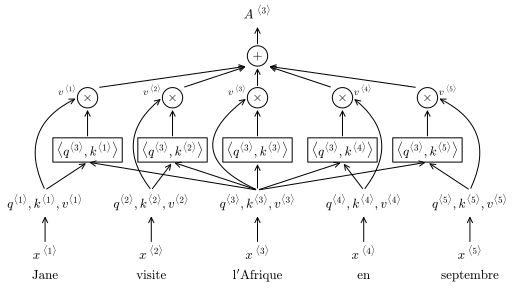

In [2]:
f = Flow(bbox=dict(boxstyle='square', ec='none'), figsize=(8, 5), fontsize=13)
sentence = "Jane visite l'Afrique en septembre".split()
label = lambda b, i: '${}^{{ \\; \\langle {} \\rangle}}$'.format(b, i)

for i, (w, displ) in enumerate(zip(sentence, (np.arange(1, len(sentence)+1)-3)/5)):
    f.node(f'x{i+1}', startpoint=f'x{i}', label=label('x', i+1), connect=False)
    f.node(f'w{i+1}', distance=.4, startpoint=f'x{i+1}', label=f'$\\mathrm{{{w}}}$', 
           connect=False, travel='s')
    f.node(f'qkv{i+1}', travel='n', startpoint=f'x{i+1}',
           label=f'$q^{{\\langle {i+1} \\rangle}}, k^{{\\langle {i+1} \\rangle}},v^{{\\langle {i+1} \\rangle}}$')
    f.node(f'ip{i+1}', travel='nw', distance=(displ, 1), bbox=dict(ec='k'),
           label=f'$\\left \\langle q^{{\\langle 3 \\rangle}}, k^{{\\langle {i+1} \\rangle}} \\right \\rangle$', 
           edge_kwargs=dict(headport='s', tailport='n'))
    f.node(f'v{i+1}', label='$\\times$', bbox=dict(boxstyle='circle', ec='k'), travel='n',
           startpoint=f'ip{i+1}', xlabel=label('v', i+1), xlabel_xy=(-.5 if i<3 else 1.5, 0.8))

f.node('+', label='$+$', travel='n', startpoint='v3', distance=.8,
       bbox=dict(boxstyle='circle', ec='k'))
f.node('A3', label=label('A', 3), travel='n', startpoint='+', distance=.8)

for i, r in zip(range(len(sentence)), [.5, .5, .85, -.5, -.5]):
    if i !=2:
        f.edge('qkv3', f'ip{i+1}', headport='s', tailport='n')
        f.edge(f'v{i+1}', '+')
    hp = 'w' if i < 3 else 'e'
    f.edge(f'qkv{i+1}', f'v{i+1}', tailport='n', headport=hp, 
           arrowprops=dict(connectionstyle=f'arc3,rad={r}'))

<i id="fig:selfattention">Self attention mechanism for the computation of the self-attention representation $A^{\langle 3 \rangle}$. A set of query, key, value vectors ($q, k, v$) are learned for each word $x$. The best context-dependent embedding is computed for the word $x^{\langle 3 \rangle}$ as the inner product of query and key $\langle q, k \rangle$. The softmax vector of the inner products is multiplied by the value vector $v$, which summed together constitutes the self-attention representation $A^{\langle 3 \rangle}$ </i>


The main advantage of the self-attention mechanism is that the embedding for the word `l'Afrique` is not fixed. The self-attention mechanism realizes that `l'Afrique` is the destination of a `visite` and thus compute a more useful and context-aware representation for this word.
    
This process is repeated for each word in the sequence to obtain self-attention representations for each of them $A^{\langle i \rangle}$, which in literature is often defined in a vectorized notation
    
$$
\text{Attention}(Q,K,V) = \text{softmax} \left ( \frac{QK^T}{\sqrt{d_k}} \right)V
$$
    
where $\sqrt{d_k}$ is the **scaled dot product** used to prevent exploding gradients, and in fact another name for this model is the **scaled dot product attention** as it is presented in the original transformer architecture paper ([Vaswani et.al.2017](https://arxiv.org/abs/1706.03762))

## Multi-Head attention
The multi-head attention is a **layer** of the transformer architecture. A multi-head attention layer repeats the self attention mechanism multiple times **in parallel**. Each time we calculate self attention for a sequence it's called a **head**, thus the name multi-head attention. 

Self attention vectors are functions of $q, k, v$ vectors. In turn these vectors are obtained as defined in $\eqref{eq:qkv}$ and they are a function of the parameter matrices $W^Q, W^K, W^V$.

The parameters matrices of the first head, to which refer as $W_1^Q, W_1^K, W_1^V$ focus on asking and answering a specific question; in the example above we said that the question asked when computing $A^{\langle 3 \rangle }$ is: *What is happening there?*.

When computing the second head we will have a second set of parameter matrices $W_2^Q, W_2^K, W_2^V$, which are relative to a different question, for example it could be: *When?* , and so the largest inner product may now be $\langle q^{\langle 3 \rangle }, k^{\langle 5 \rangle } \rangle$

There will be as many heads as the number of questions asked and the number of heads is usually referred to as $h$, with a typical number of heads being 8.

The final value of the multi-head process is the concatenation of all the heads, multiplied by a parameter matrix $W_o$

$$
\text{MultiHead}(Q, K, V)=\text{concat}\left(\text{head}_1, \dots \text{head_h}\right)W_o
$$

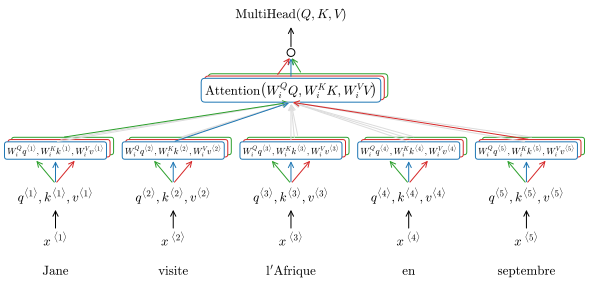

In [3]:
f = Flow(bbox=dict(boxstyle='round', ec='none'), figsize=(9, 5), fontsize=13)
sentence = "Jane visite l'Afrique en septembre".split()
label = lambda b, i: '${}^{{ \\; \\langle {} \\rangle}}$'.format(b, i)
W = lambda sup, sub, i=None: 'W_i^{}{}{}'.format(sup, sub, f'^{{\\langle {i} \\rangle}}' if i is not None else '')

for i, w in enumerate(sentence):
    f.node(f'x{i+1}', startpoint=f'x{i}', label=label('x', i+1), connect=False)
    f.node(f'w{i+1}', distance=.4, startpoint=f'x{i+1}', label=f'$\\mathrm{{{w}}}$', 
           connect=False, travel='s')
    f.node(f'qkv{i+1}', travel='n', startpoint=f'x{i+1}', distance=.6,
           label=f'$q^{{\\langle {i+1} \\rangle}}, k^{{\\langle {i+1} \\rangle}},v^{{\\langle {i+1} \\rangle}}$')
    f.node(f'W{i+1}.1', travel='n', bbox=dict(ec='C0'), fontsize=9, distance=.6, connect=False,
           label='${}$'.format(','.join([W('Q', 'q', i+1), W('K', 'k', i+1), W('V','v', i+1)])), 
           edge_kwargs=dict(headport='s', tailport='n'))
    f.node(f'W{i+1}.2', travel='ne', bbox=dict(ec='C3'), fontsize=9, distance=.03,
           label='${}$'.format(','.join([W('Q', 'q', i+1), W('K', 'k', i+1), W('V','v', i+1)])), 
           connect=False, startpoint=f'W{i+1}.1', zorder=-10)
    f.node(f'W{i+1}.3', travel='ne', bbox=dict(ec='C2'), fontsize=9, distance=.03,
       label='${}$'.format(','.join([W('Q', 'q', i+1), W('K', 'k', i+1), W('V','v', i+1)])), 
       connect=False, startpoint=f'W{i+1}.2', zorder=-20)
    

f.node('A.1',
       label='$\mathrm{{Attention}}\\left({}\\right)$'.format(','.join([W('Q', 'Q'), W('K', 'K'), W('V','V')])), 
       travel='n', startpoint='W3.1', distance=.8, connect=False,
       bbox=dict(ec='C0'))
f.node('A.2', zorder=-10,
       label='$\mathrm{{Attention}}\\left({}\\right)$'.format(','.join([W('Q', 'Q'), W('K', 'K'), W('V','V')])), 
       travel='n', startpoint='W3.2', distance=.8, connect=False,
       bbox=dict(ec='C3'))
f.node('A.3', zorder=-20,
       label='$\mathrm{{Attention}}\\left({}\\right)$'.format(','.join([W('Q', 'Q'), W('K', 'K'), W('V','V')])), 
       travel='n', startpoint='W3.3', distance=.8, connect=False,
       bbox=dict(ec='C2'))
f.node('+', label=' ', fontsize=5, bbox=dict(boxstyle='circle', ec='k'), travel='n', 
       distance=.5, connect=False, startpoint='A.1')
f.node('MH', label='$\\mathrm{{MultiHead}}(Q, K, V)$', 
       travel='n', startpoint='+', distance=.5)
f.edge('A.1', '+', arrowprops=dict(ec='C0'), tailport='n')
f.edge('A.2', '+', arrowprops=dict(ec='C3'), tailport=(0.4, 1), headport='s')
f.edge('A.3', '+', arrowprops=dict(ec='C2'), tailport=(0.52, 1), headport='s')
    
for i in range(len(sentence)):
    f.edge(f'qkv{i+1}', f'W{i+1}.1', arrowprops=dict(ec='C0'))
    f.edge(f'qkv{i+1}', f'W{i+1}.1', arrowprops=dict(ec='C2'), headport=(0.3, 0))
    f.edge(f'qkv{i+1}', f'W{i+1}.1', arrowprops=dict(ec='C3'), headport=(0.7, 0))

    if i != 1:
        f.edge(f'W{i+1}.1', 'A.1', headport='s', tailport='n',
               arrowprops=dict(ec='gainsboro'))
    if i != 4:
        f.edge(f'W{i+1}.2', 'A.1', headport='s', tailport='n',
               arrowprops=dict(ec='gainsboro'))
    if i != 0:
        f.edge(f'W{i+1}.3', 'A.1', headport='s', tailport='n',
               arrowprops=dict(ec='gainsboro'))
    if i == 1:
        f.edge(f'W{i+1}.1', 'A.1', headport='s', tailport='n',
               arrowprops=dict(ec='C0'))
    if i == 4:
        f.edge(f'W{i+1}.2', 'A.1', headport='s', tailport='n',
               arrowprops=dict(ec='C3'))
    if i == 0:
        f.edge(f'W{i+1}.3', 'A.1', headport='s', tailport='n',
               arrowprops=dict(ec='C2'))

<i id="fig:multihead">Processing of multiple heads (self-attention mechanisms). Multiple context-dependent embeddings (self-attention representations or heads) are computed in parallel to answer different queries $q$. The heads are then concatenated in the final output</i>

The different heads are independent computations and can thus be calculated **in parallel**; after the computation of all the heads is completed, the self-attention vectors are concatenated and multiplied by a parameter matrix $W_o$.

## Transformer network
A transformer is made of an **encoder block** and a **decoder block**, each repeated $N$ times (with a typical value being $N=6$). The encoder block produces an encoding of the input sequence, the decoder block maps the encoding to an output sequence.

### Encoder Decoder blocks
The encoder block has a multi-head attention layer, which is fed the vectors $Q, K, V$ computed for the input sequence. The multi-head attention layer produces a matrix that is passed into a feed-forward neural network, which is the second layer of the encoder block. After repeating $N$ times the encoder feeds the results in the decoder block (<a href="#fig:transbase">figure below</a>).

At each time-step $t$ the decoder blocks is fed $[1:t]$ elements from the input sequence. These elements are fed into a multi-head attention layer, whose job is to generate the query matrix $Q$ for the next multi-head attention layer. The key-value pair matrices $K, V$ taken as input in this second multi-head attention layer are instead generated from the output of the encoder.
This architecture is designed to produce an optimal next word, given the previous words in the translation (the $[1:t]$ elements fed as $Q$) and the input sequence (encoding fed as $K, V$). The second multi-head attention layer feeds into a feed forward neural network producing an output matrix, which is fed in loop to the decoder block for $N$ times.

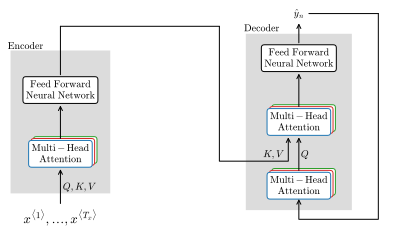

In [353]:
def multihead(f, startpoint, travel, nid, distance=1, edge_kwargs=dict()):
    a =f.node(f'{nid}.1', label='$\\mathrm{Multi-Head}$\n$\\mathrm{Attention}$',
           startpoint=startpoint, travel=travel, distance=distance,
           bbox=dict(ec='C0'), edge_kwargs=edge_kwargs)
    b =f.node(f'{nid}.2', label='$\\mathrm{Multi-Head}$\n$\\mathrm{Attention}$',
           travel='ne', distance=.03, bbox=dict(ec='C3'), connect=False, zorder=-10)
    c =f.node(f'{nid}.3', label='$\\mathrm{Multi-Head}$\n$\\mathrm{Attention}$',
           travel='ne', distance=.03, bbox=dict(ec='C2'), connect=False, zorder=-20)
    return a,b,c

def transformer():
    f = Flow()
    f.node('x', label=r'$x^{\langle 1 \rangle}, \dots , x^{\langle T_x \rangle}$', 
           bbox=dict(ec='none'), fontsize=13)
    multihead(f, 'x', 'n', 'ME', 
              edge_kwargs=dict(
                  label='$Q, K, V$', labelpos=(5, 0.5)))
    f.node('ffnnE', label='$\\mathrm{Feed \\ Forward}$\n$\\mathrm{Neural\\ Network}$',
           travel='n', startpoint='ME.1')
    f.node('compound_edge1', label='', distance=1, travel='n',
           edge_kwargs=dict(arrowprops=dict(arrowstyle='-', shrinkA=0), 
                            headport=(0.5, 0.5)))
    f.node('compound_edge2', label='', distance=2, travel='e',
       edge_kwargs=dict(arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0), 
                        headport=(0.5, 0.5), tailport=(0.5, 0.5)))
    
    multihead(f, 'compound_edge2', 'se', 'MD2', distance=(1, 1.5), 
              edge_kwargs=dict(
                  label='$K, V$', labelpos=(.75, 0.05), 
                  tailport=(0.5, 0.5), headport=(0.334, 0), 
                  arrowprops=dict( 
                      shrinkB=0,
                      connectionstyle='bar,fraction=-0.2,angle=0')))
    multihead(f, 'MD2.1', 's', 'MD1', 
              edge_kwargs=dict(
                  arrowprops=dict(arrowstyle='->'), 
                  label='$Q$', labelpos=(2, 0.5)))
    f.node('ffnnD', label='$\\mathrm{Feed \\ Forward}$\n$\\mathrm{Neural\\ Network}$',
       travel='n', startpoint='MD2.1')
    f.node('y', label='$\\hat{y}_n$', travel='n', distance=.7, bbox=dict(ec='none'))
    f.node('compound_edge1', label='', distance=1, travel='e',
       edge_kwargs=dict(arrowprops=dict(arrowstyle='-', shrinkA=0), 
                        headport=(0.5, 0.5)))
    f.edge('compound_edge1', 'MD1.1', 
           arrowprops=dict(
               arrowstyle='<-', connectionstyle='bar,fraction=0.1,angle=0',
               shrinkA=0, shrinkB=0), 
           headport='s', tailport=(0.5, 0.5))
    f.node('encoder', label='\n\n\n', startpoint='x', travel='n', distance=1.5,
           bbox=dict(boxstyle='square', ec='none', fc='gainsboro', pad=5), 
           zorder=-30, connect=False, 
           xlabel='$\\mathrm{Encoder}$', xlabel_xy=(0.15, 1.03))
    f.node('encoder', label='  \n\n\n\n\n\n', startpoint='MD2.1', distance=0,
       bbox=dict(boxstyle='square', ec='none', fc='gainsboro', pad=5), 
       zorder=-30, connect=False, 
       xlabel='$\\mathrm{Decoder}$', xlabel_xy=(0.15, 1.03))
    return f

transformer();

<i id="fig:transbase">Simplified representation of a transformer network focusing on the encoder and decoder blocks and their main components</i>

### Positional encoding and skip-connections
In the self-attention model we didn't talk about any encoding of the position of an element in the sequence. However, position is a fundamental piece of information when treating with sequences. 

In Transformers a **positional-embedding** vector $P$ of the same dimension $d$ of the self-attention embedding vector is function of the numerical position of an element in the sequence ($\small\text{pos}$), $P$ and $d$ (<a href="#fig:posenc">figure below</a>).

$$
\begin{split}
P(\small\text{pos}, 2t) &= \sin \left( \frac{\small\text{pos}}{10000^{\frac{2t}{d}}} \right) \\
P(\small\text{pos}, 2t+1)& = \cos \left( \frac{\small\text{pos}}{10000^{\frac{2t}{d}}} \right)
\end{split}
$$

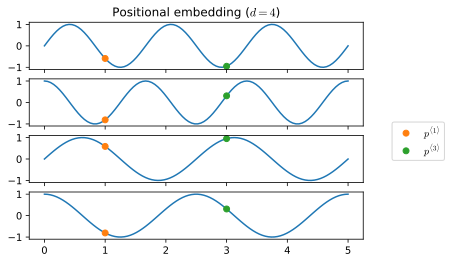

In [249]:
fig, axes = plt.subplots(4, 1, sharex='col')
ax1, ax2, ax3, ax4 = axes.ravel()
x = np.linspace(0, 6*np.pi, 100)
ax1.plot(x, np.sin(x))
ax2.plot(x, np.cos(x))
ax3.plot(x, np.sin(x/1.5))
ax4.plot(x, np.cos(x/1.5))

xticks = np.linspace(0, 6*np.pi, 6)

ax1.plot(xticks[1], np.sin(xticks[1]), ls='none', marker='o', label=r'$p^{\langle 1 \rangle}$')
ax2.plot(xticks[1], np.cos(xticks[1]), ls='none', marker='o')
ax3.plot(xticks[1], np.sin(xticks[1]/1.5), ls='none', marker='o')
ax4.plot(xticks[1], np.cos(xticks[1]/1.5), ls='none', marker='o')

ax1.plot(xticks[3], np.sin(xticks[3]), ls='none', marker='o', label=r'$p^{\langle 3 \rangle}$')
ax2.plot(xticks[3], np.cos(xticks[3]), ls='none', marker='o')
ax3.plot(xticks[3], np.sin(xticks[3]/1.5), ls='none', marker='o')
ax4.plot(xticks[3], np.cos(xticks[3]/1.5), ls='none', marker='o')

for ax in axes.ravel():
    ax.set_xticks(xticks)
    ax.set_xticklabels([0, 1, 2, 3, 4, 5])

ax1.set_title('Positional embedding ($d=4$)')
fig.legend(bbox_transform=fig.transFigure, bbox_to_anchor=(1.1, 0.55));

<i id="fig:posenc">Positional embedding $P$ of dimension $d=4$ for elements with positions $\text{pos}=1$ (orange points) and $\text{pos}=3$ (green points) in a sequence</i>

The positional embedding is directly added to the encoder and decoder blocks of the transformer. The information of the positional embedding is then propagated throughout the whole network via **skip-connections**. Skip connections are directed to **normalization layers** placed after each multi-head and feed-forward layer in both encoder and decoder blocks. This normalization layers are called **Add & Norm** layers. Finally, the decoder block feeds to a linear and softmax layer that produce the final output (<a href="#transfarch">figure below</a>).  

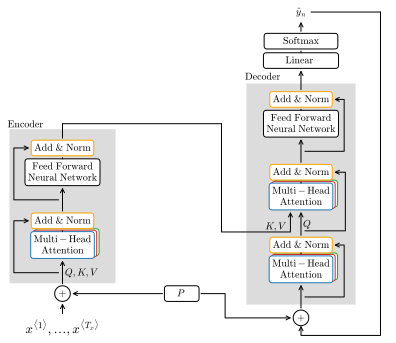

In [399]:
f = Flow(figsize=(6, 6))
f.node('x', label=r'$x^{\langle 1 \rangle}, \dots , x^{\langle T_x \rangle}$', 
       bbox=dict(ec='none'), fontsize=13)
f.node('peE', label='$+$', bbox=dict(boxstyle='circle'), travel='n', distance=.7)
(_, me),_, _ = multihead(f, 'peE', 'n', 'ME', distance=1,
          edge_kwargs=dict(
              label='$Q, K, V$', labelpos=(5, 0.5)))
f.node('an1', label='$\\mathrm{Add \\ & \\ Norm}$', travel='n', 
       bbox=dict(ec='orange'), startpoint='ME.1', distance=.5,
       edge_kwargs=dict(arrowprops=dict(arrowstyle='-')))
_, ffe = f.node('ffnnE', label='$\\mathrm{Feed \\ Forward}$\n$\\mathrm{Neural\\ Network}$',
       travel='n')
f.node('an2', label='$\\mathrm{Add \\ & \\ Norm}$', travel='n', 
       bbox=dict(ec='orange'), distance=.5,
       edge_kwargs=dict(arrowprops=dict(arrowstyle='-')))
f.node('compound_edge1', label='', distance=.5, travel='n',
       edge_kwargs=dict(arrowprops=dict(arrowstyle='-', shrinkA=0), 
                        headport=(0.5, 0.5)))
f.node('compound_edge2', label='', distance=2, travel='e',
   edge_kwargs=dict(arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0), 
                    headport=(0.5, 0.5), tailport=(0.5, 0.5)))

(_, md1), _, _ = multihead(f, 'compound_edge2', 'se', 'MD2', distance=(1, 1.5), 
          edge_kwargs=dict(
              label='$K, V$', labelpos=(.75, 0.05), 
              tailport=(0.5, 0.5), headport=(0.334, 0), 
              arrowprops=dict( 
                  shrinkB=0,
                  connectionstyle='bar,fraction=-0.2,angle=0')))
_, an3 = f.node('an3', label='$\\mathrm{Add \\ & \\ Norm}$', travel='s', 
       bbox=dict(ec='orange'), distance=1, startpoint='MD2.1',
       edge_kwargs=dict(
           arrowprops=dict(arrowstyle='->'), 
           label='$Q$', labelpos=(2, 0.5)))
(_, md1), _, _ = multihead(f, 'an3', 's', 'MD1', distance=.5,
          edge_kwargs=dict(
              arrowprops=dict(arrowstyle='-')))

_, an4 = f.node('an4', label='$\\mathrm{Add \\ & \\ Norm}$', travel='n', 
       bbox=dict(ec='orange'), distance=.5, startpoint='MD2.1',
       edge_kwargs=dict(arrowprops=dict(arrowstyle='-')))

_, ffd= f.node('ffnnD', label='$\\mathrm{Feed \\ Forward}$\n$\\mathrm{Neural\\ Network}$',
   travel='n', startpoint='an4')
f.node('an5', label='$\\mathrm{Add \\ & \\ Norm}$', travel='n', 
       bbox=dict(ec='orange'), distance=.5, startpoint='ffnnD',
       edge_kwargs=dict(arrowprops=dict(arrowstyle='-')))
f.node('lin', label='$\\mathrm{Linear}$'.center(30), travel='n', distance=.8)
f.node('soft', label='$\\mathrm{Softmax}$'.center(28), travel='n', distance=.4, 
       edge_kwargs=dict(arrowprops=dict(arrowstyle='-')))
f.node('y', label='$\\hat{y}_n$', travel='n', distance=.6, bbox=dict(ec='none'))
f.node('compound_edge1', label='', distance=1, travel='e',
   edge_kwargs=dict(arrowprops=dict(arrowstyle='-', shrinkA=0), 
                    headport=(0.5, 0.5)))
_, pd = f.node('peD', label='$+$', bbox=dict(boxstyle='circle'), travel='s', startpoint='MD1.1', 
       distance=1, edge_kwargs=dict(arrowprops=dict(arrowstyle='->')))
f.node('P', label='$P$'.center(10), distance=1.5, startpoint='peE', 
       edge_kwargs=dict(arrowprops=dict(arrowstyle='->')))
f.edge('P', 'peD', headport='w', tailport='e', 
       arrowprops=dict(connectionstyle='bar,fraction=-0.7,angle=90'))
f.edge('compound_edge1', 'peD', 
       arrowprops=dict(
           arrowstyle='<-', connectionstyle='bar,fraction=0.03,angle=0',
           shrinkA=0, shrinkB=0), 
       headport='s', tailport=(0.5, 0.5))
f.node('encoder', label='  \n\n\n\n', startpoint='x', travel='n', distance=2.5,
       bbox=dict(boxstyle='square', ec='none', fc='gainsboro', pad=5), 
       zorder=-30, connect=False, 
       xlabel='$\\mathrm{Encoder}$', xlabel_xy=(0.15, 1.03))
f.node('encoder', label='   \n\n\n\n\n\n\n\n\n\n', startpoint='MD2.1', distance=.05, travel='n',
   bbox=dict(boxstyle='square', ec='none', fc='gainsboro', pad=5), 
   zorder=-30, connect=False, 
   xlabel='$\\mathrm{Decoder}$', xlabel_xy=(0.15, 1.03))
f.edge(me, 'an1', tailport='w', headport='w', arrowprops=dict(connectionstyle='bar,fraction=-0.2,angle=90'))
f.edge(ffe, 'an2', tailport='w', headport='w', arrowprops=dict(connectionstyle='bar,fraction=-0.2,angle=90'))
f.edge(pd, 'an3', tailport='e', headport='e', arrowprops=dict(connectionstyle='bar,fraction=-0.2,angle=90'))
f.edge(an3, 'an4', tailport=(1, 0.2), headport='e',  
       arrowprops=dict(connectionstyle='bar,fraction=-0.2,angle=90'))
f.edge(ffd, 'an5', tailport=(1, 0.5), headport='e',  
       arrowprops=dict(connectionstyle='bar,fraction=-0.2,angle=90'));

<i id="fig:transfarch">Full transformer architecture with encoder and decoder blocks, positional embeddings, skip connections, normalization and final linear and softmax layers</i>